In [1]:
# !git clone https://github.com/shariqfarhan/EVA8-pytorch-cifar

In [2]:
'''
To be entered in Terminal

source $VIRTUAL_ENV_DIR/python310/bin/activate

python -m pip install pytorch-gradcam torchinfo albumentations tqdm
'''
# pip install grad-cam

# https://albumentations.ai/docs/api_reference/core/composition/


'\nTo be entered in Terminal\n\nsource $VIRTUAL_ENV_DIR/python310/bin/activate\n\npython -m pip install pytorch-gradcam torchinfo albumentations tqdm\n'

In [3]:
# !install_package_python310.sh add torch_lr_finder

In [1]:
import os
os.chdir('EVA8-pytorch-cifar')
os.listdir()

['.git',
 'data',
 'train.py',
 '__pycache__',
 'README.md',
 'test_model.py',
 'utils',
 'models']

In [2]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_lr_finder import LRFinder

import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from torchinfo import summary
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt



from models import resnet
from utils.utils import get_mean_and_std, show_data_metrics, viz_data, show_images, show_model_summary
from utils.utils import AlbumentationImageDataset, plot_train_test_acc_loss, plot_misclassified_images, denormalize, plot_gradcam
from train import train
from test_model import test, mis_classified_images

/dsw/snapshots/1fbd09c1-6300-44c5-b2e5-8ccbc2ca8da3/python310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

exp = datasets.CIFAR10('./data', train = True, download = True)
exp_data = exp.data

show_data_metrics(exp_data)


Files already downloaded and verified
Train
- Numpy Shape : (50000, 32, 32, 3)
- min : [0. 0. 0.]
- max : [1. 1. 1.]
- mean : [0.49139968 0.48215841 0.44653091]
- std. : [0.24703223 0.24348513 0.26158784]
- var : [15.56135559 15.11767693 17.44919073]


In [4]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

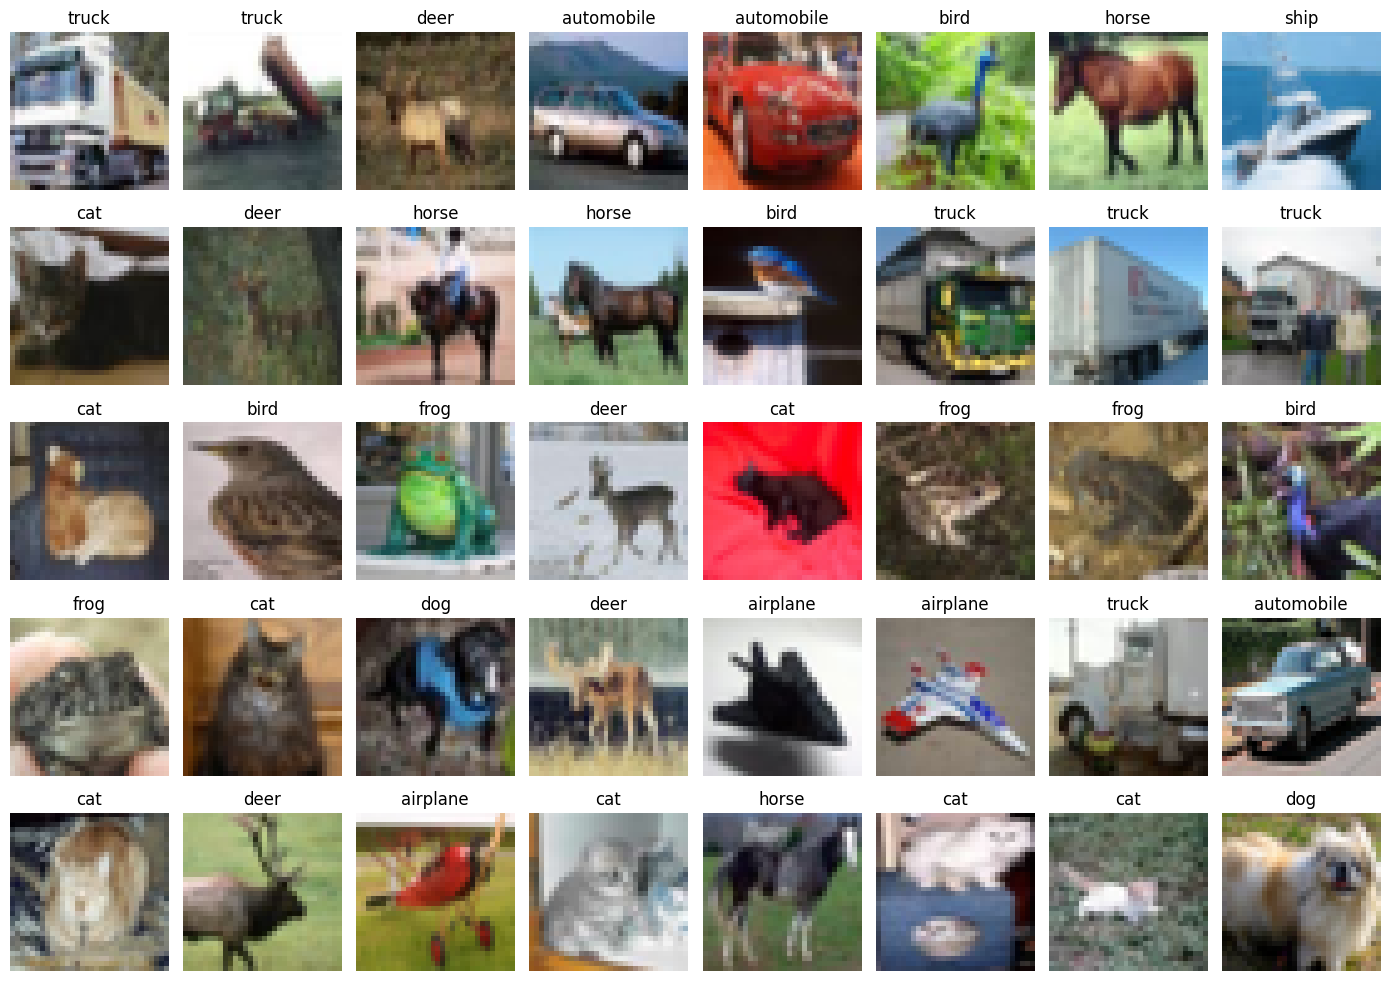

In [5]:
viz_data(exp)

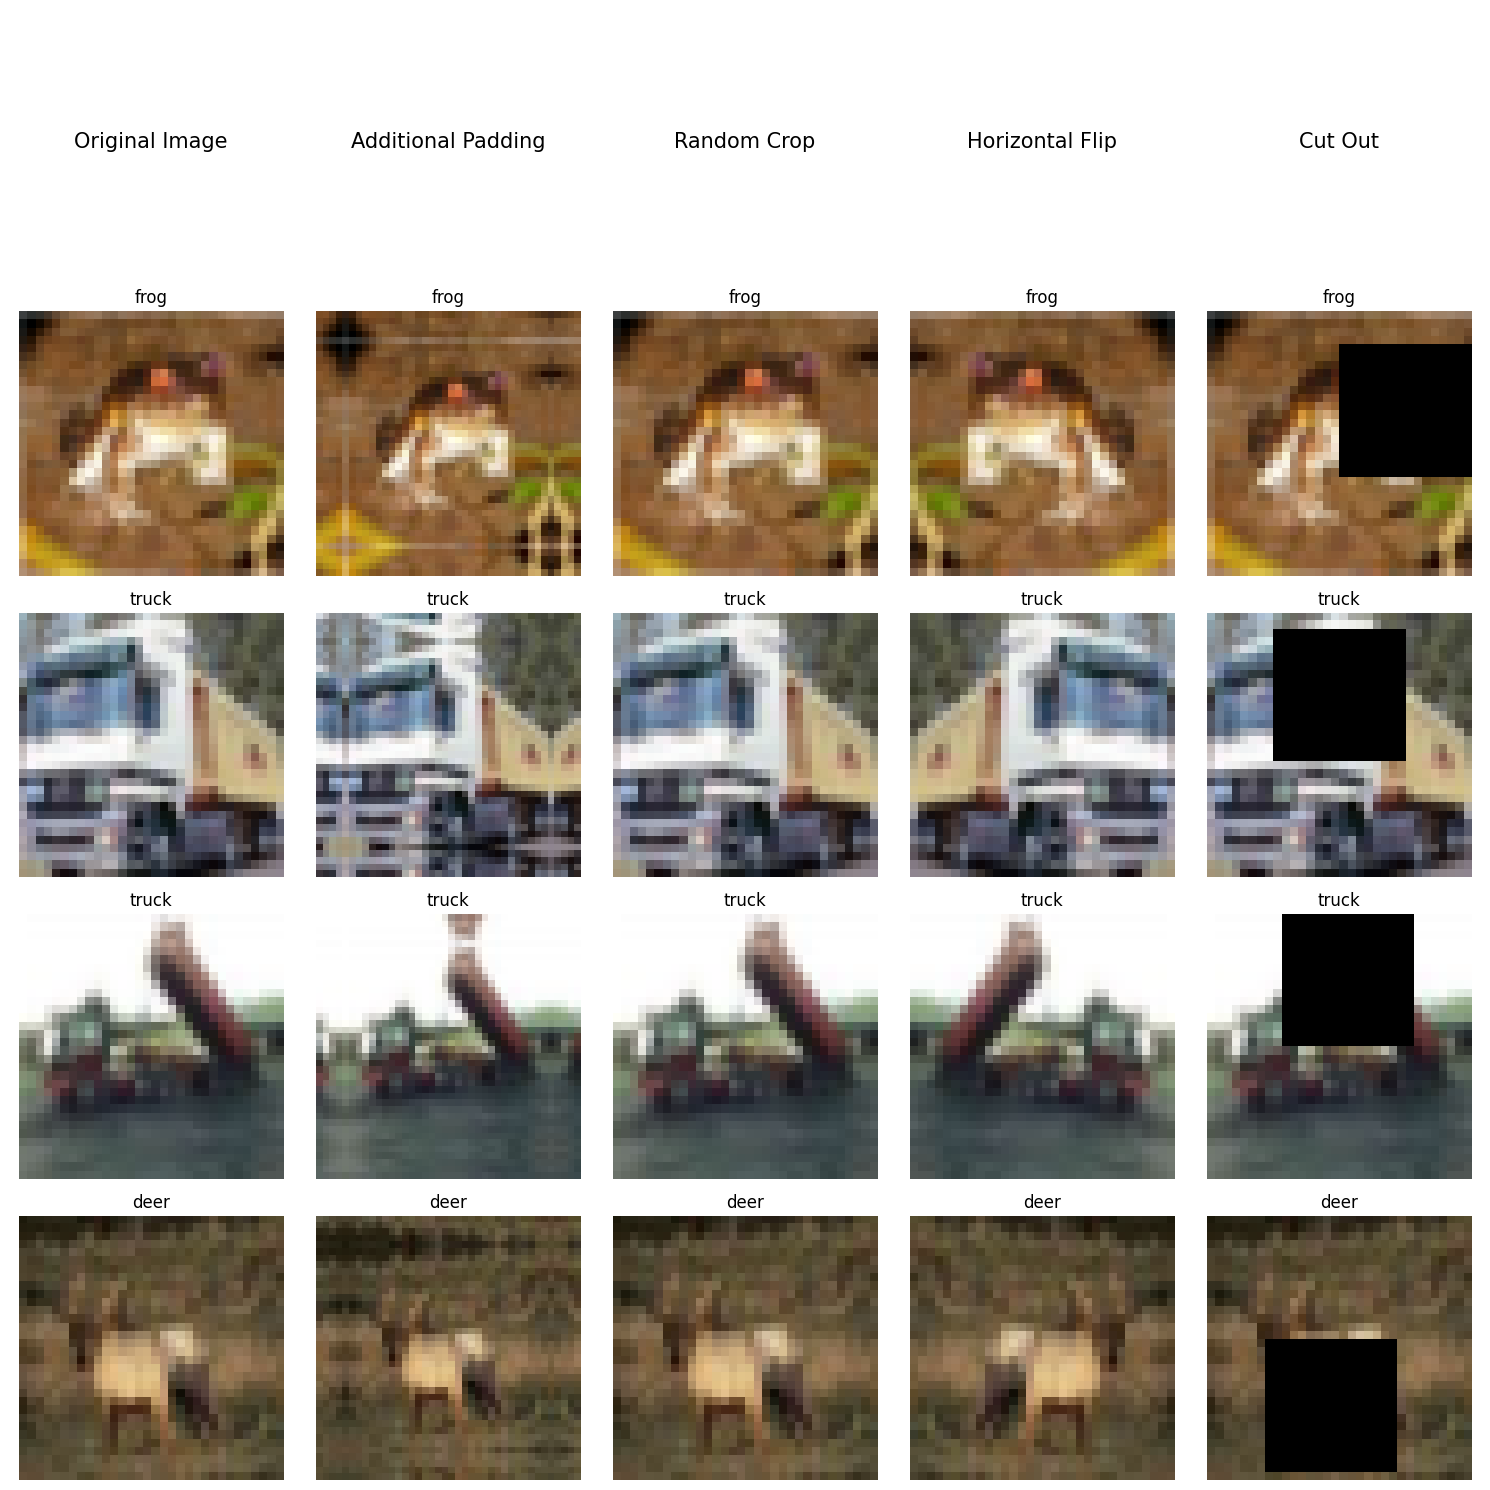

In [6]:
# RandomCrop(32, padding=4)
# CutOut(16x16)
show_images(exp,{
    'Original Image' : None,
    'Additional Padding' : A.PadIfNeeded(min_height=40, min_width=40), # Padding on both sides equal to 4 -> 32 + 2*4 = 40
    'Random Crop' : A.RandomCrop(32, 32),
    'Horizontal Flip' : A.HorizontalFlip(p=1),
    'Cut Out' : A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16,
                                min_width=16, fill_value=0.473363, mask_fill_value=None, always_apply=True)
}, ncol = 5)

In [7]:
# session_parameters()
SEED = 1

# CUDA
cuda = torch.cuda.is_available()
print("CUDA Available:", cuda)

# For Reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    BATCH_SIZE = 64
else:
    BATCH_SIZE = 64

CUDA Available: True


In [8]:
trainset = torchvision.datasets.CIFAR10(root='./data', train = True, 
                                        download = True)
testset = torchvision.datasets.CIFAR10(root='./data', train = False, 
                                        download = True)

train_loader = torch.utils.data.DataLoader(AlbumentationImageDataset(trainset, train = True),
                                          batch_size = BATCH_SIZE, shuffle=True,num_workers = 2)
test_loader = torch.utils.data.DataLoader(AlbumentationImageDataset(testset, train = False),
                                          batch_size = BATCH_SIZE, shuffle=True,num_workers = 2)

Files already downloaded and verified
Files already downloaded and verified


In [10]:

from models.model9 import Net
model = Net()
show_model_summary(model)

cuda
Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [16, 10]                  --
├─Sequential: 1-1                        [16, 16, 32, 32]          --
│    └─Conv2d: 2-1                       [16, 16, 32, 32]          432
│    └─BatchNorm2d: 2-2                  [16, 16, 32, 32]          32
│    └─ReLU: 2-3                         [16, 16, 32, 32]          --
│    └─Dropout: 2-4                      [16, 16, 32, 32]          --
├─Sequential: 1-2                        [16, 32, 32, 32]          --
│    └─Conv2d: 2-5                       [16, 32, 32, 32]          4,608
│    └─BatchNorm2d: 2-6                  [16, 32, 32, 32]          64
│    └─ReLU: 2-7                         [16, 32, 32, 32]          --
│    └─Dropout: 2-8                      [16, 32, 32, 32]          --
├─Sequential: 1-3                        [16, 48, 32, 32]          --
│    └─Conv2d: 2-9                       [16, 48, 32, 32]          13,824
│ 

In [11]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)
EPOCHS = 24

model = Net().to(device)

In [12]:
model.train()

Net(
  (convblock1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.0, inplace=False)
  )
  (convblock2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.0, inplace=False)
  )
  (convblock3): Sequential(
    (0): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.0, inplace=False)
  )
  (gap1): MaxPool2d(kernel_size=32, stride=1, padding=0, dilation=1, ceil_mode=False)
  (UltimusBlock): UltimusBlock(
    (q): Linear(in_features=48, out_features=8, bias=True)
    (k): Linear(in_features=48

 68%|██████▊   | 135/200 [00:01<00:00, 84.57it/s]


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.50E-01


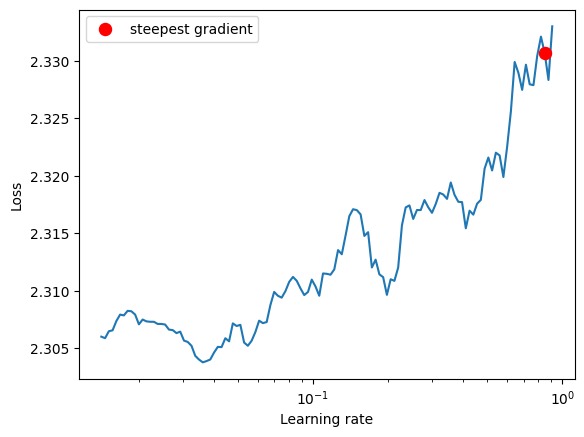

(<AxesSubplot: xlabel='Learning rate', ylabel='Loss'>, 0.8504489341802679)

In [14]:
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=10, num_iter=200)
lr_finder.plot()

In [15]:
min_loss = min(lr_finder.history['loss'])
ler_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR is {}".format(ler_rate))

Max LR is 0.03612342699709432


In [18]:
from torch.optim.lr_scheduler import StepLR

model = Net().to(device)
EPOCHS = 24
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=ler_rate,
                                                steps_per_epoch=int(len(train_loader)), 
                                                epochs=EPOCHS,
                                                pct_start=5/EPOCHS, # MAX LR at 5th Epoch
                                                anneal_strategy='linear'
                                                )
# scheduler = StepLR(optimizer, step_size=20, gamma=1)
criterion = nn.CrossEntropyLoss()
train_losses, train_acc, test_losses, test_acc = list(), list(), list(), list()
for epoch in range(1, EPOCHS+1):
    print("EPOCH: {} (LR: {})".format(epoch, optimizer.param_groups[0]['lr']))
    train(model, device, train_loader, optimizer, criterion, train_losses, train_acc, scheduler, l1_penalty=False, lambda_l1=1e-05)
    test(model, device, test_loader, test_losses, test_acc)

EPOCH: 1 (LR: 0.0014449370798837726)


Loss=2.323298454284668 Batch_id=781 Accuracy=9.71: 100%|██████████| 782/782 [00:09<00:00, 82.42it/s]  



Test set: Average loss: 2.3035, Accuracy: 1000/10000 (10.00%)

EPOCH: 2 (LR: 0.008382409352909775)


Loss=2.310532808303833 Batch_id=781 Accuracy=9.85: 100%|██████████| 782/782 [00:09<00:00, 79.01it/s] 



Test set: Average loss: 2.3030, Accuracy: 1000/10000 (10.00%)

EPOCH: 3 (LR: 0.01531988162593578)


Loss=2.310706853866577 Batch_id=781 Accuracy=9.96: 100%|██████████| 782/782 [00:09<00:00, 82.06it/s]  



Test set: Average loss: 2.3034, Accuracy: 1000/10000 (10.00%)

EPOCH: 4 (LR: 0.022257353898961784)


Loss=2.30141544342041 Batch_id=781 Accuracy=9.63: 100%|██████████| 782/782 [00:09<00:00, 82.86it/s]  



Test set: Average loss: 2.3030, Accuracy: 1000/10000 (10.00%)

EPOCH: 5 (LR: 0.029194826171987785)


Loss=2.284342050552368 Batch_id=781 Accuracy=9.84: 100%|██████████| 782/782 [00:09<00:00, 79.38it/s]  



Test set: Average loss: 2.3038, Accuracy: 1000/10000 (10.00%)

EPOCH: 6 (LR: 0.036120995762573965)


Loss=2.3111190795898438 Batch_id=781 Accuracy=10.09: 100%|██████████| 782/782 [00:09<00:00, 82.68it/s]



Test set: Average loss: 2.3032, Accuracy: 1000/10000 (10.00%)

EPOCH: 7 (LR: 0.03421977036765889)


Loss=2.304633378982544 Batch_id=781 Accuracy=10.02: 100%|██████████| 782/782 [00:09<00:00, 82.33it/s] 



Test set: Average loss: 2.3029, Accuracy: 1000/10000 (10.00%)

EPOCH: 8 (LR: 0.03231854497274383)


Loss=2.3115153312683105 Batch_id=781 Accuracy=9.71: 100%|██████████| 782/782 [00:09<00:00, 80.43it/s]



Test set: Average loss: 2.3043, Accuracy: 1000/10000 (10.00%)

EPOCH: 9 (LR: 0.030417319577828755)


Loss=2.3101935386657715 Batch_id=781 Accuracy=10.52: 100%|██████████| 782/782 [00:09<00:00, 79.85it/s]



Test set: Average loss: 2.2492, Accuracy: 1746/10000 (17.46%)

EPOCH: 10 (LR: 0.028516094182913686)


Loss=2.0955066680908203 Batch_id=781 Accuracy=19.24: 100%|██████████| 782/782 [00:09<00:00, 82.03it/s]



Test set: Average loss: 2.0631, Accuracy: 1835/10000 (18.35%)

EPOCH: 11 (LR: 0.026614868787998618)


Loss=1.6953871250152588 Batch_id=781 Accuracy=22.50: 100%|██████████| 782/782 [00:09<00:00, 79.92it/s]



Test set: Average loss: 1.8389, Accuracy: 2588/10000 (25.88%)

EPOCH: 12 (LR: 0.024713643393083545)


Loss=2.3508996963500977 Batch_id=781 Accuracy=26.54: 100%|██████████| 782/782 [00:09<00:00, 79.18it/s]



Test set: Average loss: 1.8409, Accuracy: 2442/10000 (24.42%)

EPOCH: 13 (LR: 0.022812417998168476)


Loss=1.5601086616516113 Batch_id=781 Accuracy=28.82: 100%|██████████| 782/782 [00:09<00:00, 79.39it/s]



Test set: Average loss: 1.6397, Accuracy: 3387/10000 (33.87%)

EPOCH: 14 (LR: 0.020911192603253408)


Loss=1.2927627563476562 Batch_id=781 Accuracy=32.47: 100%|██████████| 782/782 [00:09<00:00, 78.62it/s]



Test set: Average loss: 1.6988, Accuracy: 3408/10000 (34.08%)

EPOCH: 15 (LR: 0.01900996720833834)


Loss=1.6733932495117188 Batch_id=781 Accuracy=33.66: 100%|██████████| 782/782 [00:09<00:00, 81.39it/s]



Test set: Average loss: 1.5977, Accuracy: 3618/10000 (36.18%)

EPOCH: 16 (LR: 0.017108741813423266)


Loss=1.660379409790039 Batch_id=781 Accuracy=28.63: 100%|██████████| 782/782 [00:09<00:00, 80.94it/s] 



Test set: Average loss: 1.7282, Accuracy: 3240/10000 (32.40%)

EPOCH: 17 (LR: 0.015207516418508198)


Loss=1.7486686706542969 Batch_id=781 Accuracy=33.93: 100%|██████████| 782/782 [00:09<00:00, 82.24it/s]



Test set: Average loss: 1.5617, Accuracy: 3617/10000 (36.17%)

EPOCH: 18 (LR: 0.013306291023593125)


Loss=1.6327943801879883 Batch_id=781 Accuracy=35.90: 100%|██████████| 782/782 [00:09<00:00, 82.30it/s]



Test set: Average loss: 1.6336, Accuracy: 3669/10000 (36.69%)

EPOCH: 19 (LR: 0.01140506562867806)


Loss=1.4548964500427246 Batch_id=781 Accuracy=38.21: 100%|██████████| 782/782 [00:09<00:00, 80.48it/s]



Test set: Average loss: 1.5016, Accuracy: 4127/10000 (41.27%)

EPOCH: 20 (LR: 0.009503840233762988)


Loss=1.5125818252563477 Batch_id=781 Accuracy=40.60: 100%|██████████| 782/782 [00:10<00:00, 77.37it/s]



Test set: Average loss: 1.4506, Accuracy: 4348/10000 (43.48%)

EPOCH: 21 (LR: 0.007602614838847919)


Loss=1.9447730779647827 Batch_id=781 Accuracy=41.50: 100%|██████████| 782/782 [00:09<00:00, 81.14it/s]



Test set: Average loss: 1.4883, Accuracy: 4385/10000 (43.85%)

EPOCH: 22 (LR: 0.00570138944393285)


Loss=1.9937145709991455 Batch_id=781 Accuracy=43.57: 100%|██████████| 782/782 [00:09<00:00, 79.86it/s]



Test set: Average loss: 1.4136, Accuracy: 4621/10000 (46.21%)

EPOCH: 23 (LR: 0.0038001640490177777)


Loss=1.393161416053772 Batch_id=781 Accuracy=45.62: 100%|██████████| 782/782 [00:09<00:00, 81.99it/s] 



Test set: Average loss: 1.3570, Accuracy: 4784/10000 (47.84%)

EPOCH: 24 (LR: 0.0018989386541027123)


Loss=1.9116569757461548 Batch_id=781 Accuracy=47.76: 100%|██████████| 782/782 [00:09<00:00, 80.83it/s]



Test set: Average loss: 1.3424, Accuracy: 4914/10000 (49.14%)



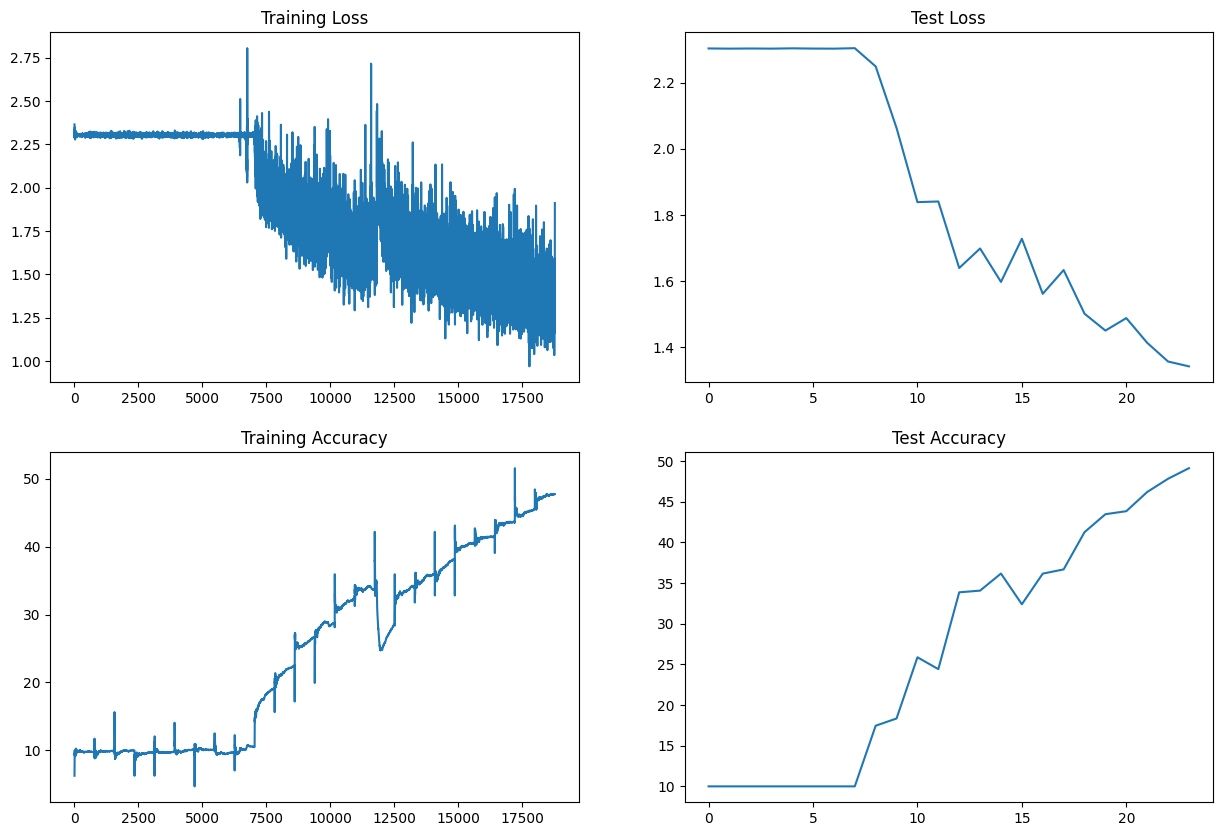

In [19]:
plot_train_test_acc_loss(train_losses, train_acc, test_losses, test_acc)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

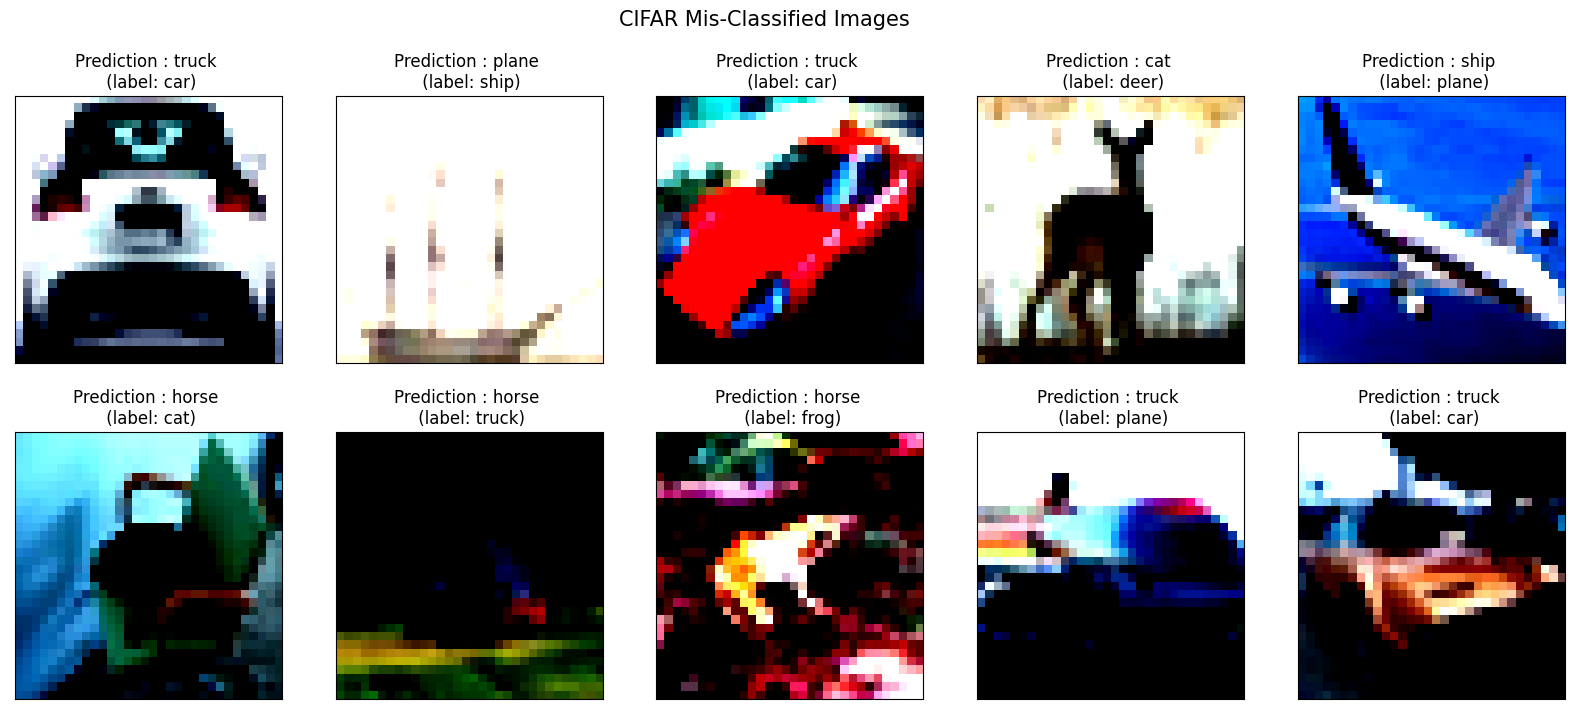

In [20]:


# Identify incorrect classifications
incorr_X, incorr_y, incorr_argmax = mis_classified_images(model, device, test_loader) 

#Plot the images
plot_misclassified_images(incorr_X, incorr_y, incorr_argmax, classes)

Factor =  0  , Learning Rate =  0.0004
Factor =  1  , Learning Rate =  0.0028000000000000004
Factor =  2  , Learning Rate =  0.005200000000000001
Factor =  3  , Learning Rate =  0.007600000000000001
Factor =  4  , Learning Rate =  0.01
Factor =  5  , Learning Rate =  0.009473686315789475
Factor =  6  , Learning Rate =  0.008947372631578947
Factor =  7  , Learning Rate =  0.008421058947368422
Factor =  8  , Learning Rate =  0.007894745263157895
Factor =  9  , Learning Rate =  0.007368431578947369
Factor =  10  , Learning Rate =  0.006842117894736842
Factor =  11  , Learning Rate =  0.006315804210526316
Factor =  12  , Learning Rate =  0.00578949052631579
Factor =  13  , Learning Rate =  0.005263176842105264
Factor =  14  , Learning Rate =  0.004736863157894737
Factor =  15  , Learning Rate =  0.00421054947368421
Factor =  16  , Learning Rate =  0.0036842357894736845
Factor =  17  , Learning Rate =  0.003157922105263157
Factor =  18  , Learning Rate =  0.0026316084210526317
Factor =  19 

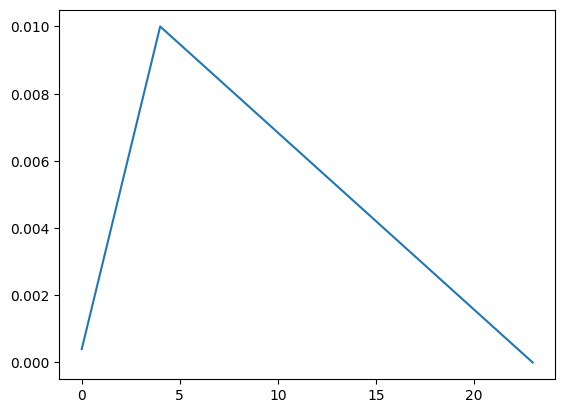

In [36]:
lrs = []


for i in range(EPOCHS):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    print("Factor = ",i," , Learning Rate = ",optimizer.param_groups[0]["lr"])
    scheduler.step()

plt.plot(lrs)